In [63]:
import matplotlib as plt
import util
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np
import os

from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline



In [105]:
# Global constants describing the Tiny Imagenet data set.
INPUT_SHAPE = [None, 64, 64, 3]
IMAGE_SHAPE = [64, 64, 3]
CROPPED_IMAGE_SHAPE = [56, 56, 3]
OFFSET_HEIGHT = 4
OFFSET_WIDTH = 4
TARGET_HEIGHT = 56
TARGET_WIDTH = 56


INPUT_NAME = 'images'
NUM_CLASSES = 200 
NUM_TRAINING_FILES = 10 

# Define input pipelines
def scale_image(image):

    """Scales image pixesl between -1 and 1"""
    image = image / 127.5
    image = image - 1.
    return image

  
def _parse(example_proto, augment):
  features = tf.parse_single_example(
        example_proto,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
  image = tf.decode_raw(features['image'], tf.uint8)
  #image = tf.cast(image, tf.float32)
  #image = scale_image(image)
  image = tf.reshape(image, IMAGE_SHAPE)
  
  if augment:
    image = tf.random_crop(image, CROPPED_IMAGE_SHAPE)
    image = tf.image.random_flip_left_right(image)
  else:
    image = tf.image.crop_to_bounding_box(image, OFFSET_HEIGHT, OFFSET_WIDTH, TARGET_HEIGHT, TARGET_WIDTH)
     
  label = features['label']
  label = tf.one_hot(label, NUM_CLASSES)
    
  return image, label


def get_filenames(is_training, data_dir):
    if is_training:
        files = [os.path.join(data_dir, "training_{0}.tfrecords".format(i+1)) for i in range(NUM_TRAINING_FILES)]
    else: 
        files = [os.path.join(data_dir, "validation.tfrecords")]
    return files
        
    
def input_fn(data_dir, is_training, batch_size, num_parallel_calls, shuffle_buffer=10000):
 
  files = get_filenames(is_training, data_dir)
  dataset = tf.data.Dataset.from_tensor_slices(files)
  
  # Shuffle the input files
  #if is_training:
  #  dataset = dataset.shuffle(buffer_size=NUM_TRAINING_FILES)
   
  # Convert to individual records
  dataset = dataset.flat_map(tf.data.TFRecordDataset)
    
  # Prefetch a batch at a time
  dataset = dataset.prefetch(buffer_size=batch_size)
    
  # Shuffle the records
  #if is_training:
  #  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  
  dataset = dataset.repeat(None if is_training else 1)
    
  # Parse records
  parse = lambda x: _parse(x, is_training)
  dataset = dataset.map(parse, num_parallel_calls=num_parallel_calls)
  
  # Batch, prefetch, and serve
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=1)
  
  iterator = dataset.make_one_shot_iterator()
  image_batch, label_batch = iterator.get_next()
  
  return {INPUT_NAME: image_batch}, label_batch


In [106]:
data_dir = '../data/tiny-imagenet'

images_dict, labels_t = input_fn(data_dir, True, 6, 6)

images_t = images_dict['images']

with tf.Session() as sess:
    images, labels = sess.run([images_t, labels_t])

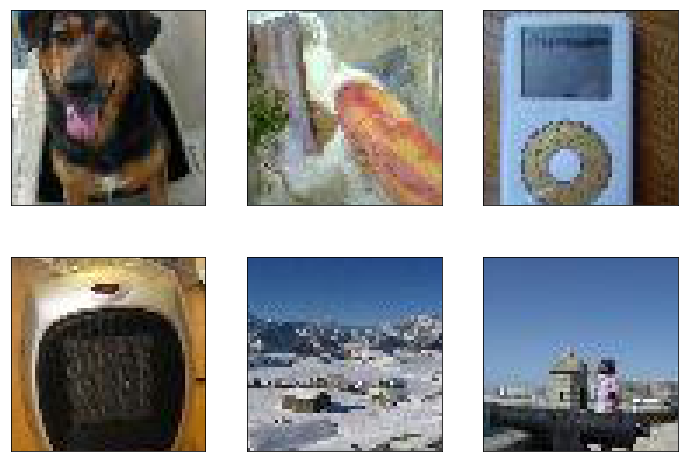

In [107]:
figsize=(10, 7)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, image in zip(axis.flat[0:], images):
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

In [108]:
data_dir = '../data/tiny-imagenet'

images_dict, labels_t = input_fn(data_dir, False, 6, 6)

images_t = images_dict['images']

with tf.Session() as sess:
    images, labels = sess.run([images_t, labels_t])

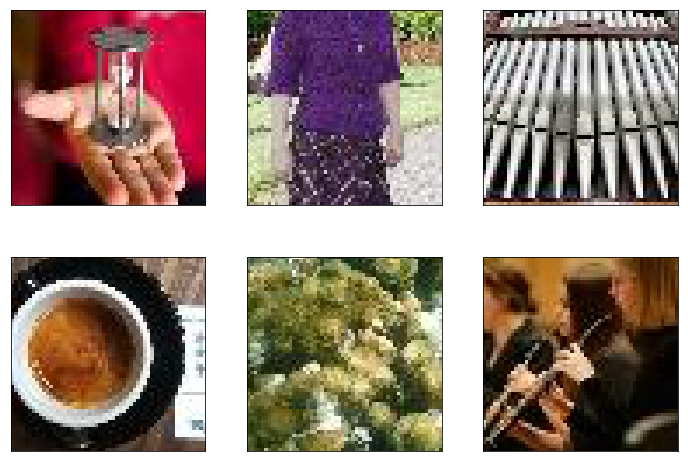

In [109]:
figsize=(10, 7)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, image in zip(axis.flat[0:], images):
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)